In [1]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [39]:
import joblib
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [5]:
!mkdir data

In [6]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [7]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [8]:
df = pd.io.sql.read_sql(
    """
    select uid, labname, numTrials, timestamp
    from checker
    where uid like 'user_%' and status = 'ready'
    """,
    conn, parse_dates=['timestamp']
    )

In [9]:
conn.close()

In [10]:
df['hour'] = df['timestamp'].dt.hour
dayofweek = df['timestamp'].dt.dayofweek
df = df.drop('timestamp', axis=1)

In [11]:
df = pd.get_dummies(df, prefix=['uid', 'labname'], columns=['uid', 'labname'])

In [12]:
df['dayofweek'] = dayofweek

In [13]:
df.head()

,numTrials,hour,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,uid_user_18,uid_user_19,uid_user_2,uid_user_20,uid_user_21,uid_user_22,uid_user_23,uid_user_24,uid_user_25,uid_user_26,uid_user_27,uid_user_28,uid_user_29,uid_user_3,uid_user_30,uid_user_31,uid_user_4,uid_user_6,uid_user_7,uid_user_8,labname_code_rvw,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1,dayofweek
0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
1,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
2,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
3,4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
4,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('dayofweek', axis=1), df['dayofweek'],
    test_size=0.2, random_state=21, stratify=df['dayofweek']
    )

In [23]:
svc = SVC(C=10, gamma='auto', probability=True, random_state=21)

In [24]:
svc.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=21, shrinking=True, tol=0.001,
    verbose=False)

In [25]:
y_pred = svc.predict(X_test)
y_score = svc.predict_proba(X_test)

In [26]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_score, average='weighted', multi_class='ovo'):.5f}")

Accuracy: 0.88757
Precision: 0.89267
Recall: 0.88757
ROC AUC: 0.97891


In [27]:
tree = DecisionTreeClassifier(max_depth=27, class_weight='balanced',
                              random_state=21)

In [28]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=27, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [29]:
y_pred = tree.predict(X_test)
y_score = tree.predict_proba(X_test)

In [30]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_score, average='weighted', multi_class='ovo'):.5f}")

Accuracy: 0.90237
Precision: 0.90360
Recall: 0.90237
ROC AUC: 0.94013


In [35]:
forest = RandomForestClassifier(n_estimators=50, max_depth=28, random_state=21)

In [36]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=28, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [37]:
y_pred = forest.predict(X_test)
y_score = forest.predict_proba(X_test)

In [38]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.5f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_score, average='weighted', multi_class='ovo'):.5f}")

Accuracy: 0.92899
Precision: 0.93009
Recall: 0.92899
ROC AUC: 0.99033


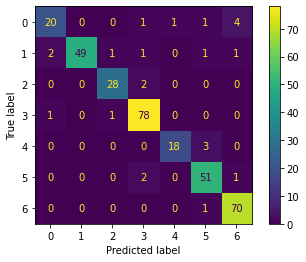

In [40]:
plot_confusion_matrix(forest, X_test, y_test)
plt.show()

In [41]:
joblib.dump(forest, 'model.joblib')

['model.joblib']

In [44]:
def calculate_metrics(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    y_score = estimator.predict_proba(X_test)
    return {'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_test, y_score, average='weighted',
                                     multi_class='ovo')}